# Medicare Advantage vs Traditional: Utilization Disparities Analysis

This notebook investigates whether Medicare Advantage (MA) enrollees receive fewer medical provider visits than those in Traditional Medicare (TM), even when controlling for key patient characteristics.

## Background
Medicare Advantage plans are known for restrictive networks, prior authorization policies, and care management strategies. While often touted for cost efficiency, concerns remain about underutilization — especially for patients with greater health needs.

## Objective
Determine whether MA enrollees have fewer medical provider visits than TM enrollees **after adjusting for**:
- Number of chronic conditions
- Age group
- Sex
- Income level

## Methodology
We use the 2022 CSPUF dataset and perform a **weighted linear regression** with:
- Outcome variable: `MPAEVNTS` (Medical Provider Events)
- Predictor: `plan_ma` (binary flag for Medicare Advantage)
- Covariates: chronic conditions, age (categorical), sex (categorical), income (categorical)
- Weights: `CSPUFWGT` (survey weight)

## Key Finding
**Being enrolled in Medicare Advantage is associated with approximately 5.6 fewer medical provider visits per year**, even after adjusting for demographics and health status.

This difference is **statistically significant (p < 0.001)** and persists across levels of chronic conditions.

## Interpretation
While demographic differences between MA and TM enrollees were minimal in this dataset, MA consistently delivers **less care**. This may point to structural barriers, plan-level restrictions, or systemic incentives to suppress utilization.

---

### Next Steps
- Visualize coefficient effects
- Stratify by additional variables (e.g., dual-eligibility, geography)
- Investigate downstream impacts (e.g., hospitalizations, mortality)

---

*This analysis is based on publicly available Medicare survey data and is fully reproducible.*


In [1]:
# Medicare Advantage vs Traditional Medicare: CSPUF 2022 Analysis

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option("display.float_format", "{:,.0f}".format)

In [3]:
# Load data
df = pd.read_csv("Data/cspuf2022.csv")

/var/folders/cs/kmj61n214fb_04mwj7x077tm0000gn/T/ipykernel_56301/2786932427.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Data/cspuf2022.csv")


In [4]:

# Convert columns to numeric
df["CSP_NCHRNCND"] = pd.to_numeric(df["CSP_NCHRNCND"], errors="coerce")
df["MPAEVNTS"] = pd.to_numeric(df["MPAEVNTS"], errors="coerce")
df["CSPUFWGT"] = pd.to_numeric(df["CSPUFWGT"], errors="coerce")


In [5]:


# Define weighted mean function
def weighted_mean(series, weights):
    return (series * weights).sum() / weights[series.notnull()].sum()



In [6]:
# Build summarized data for plotting
summary_data = []

for conditions in [1, 2, 3]:
    trad_mask = (df["PAMTCARE"] > 0) & (df["CSP_NCHRNCND"] == conditions)
    ma_mask = (df["PAMTMADV"] > 0) & (df["CSP_NCHRNCND"] == conditions)

    trad_visits = weighted_mean(df.loc[trad_mask, "MPAEVNTS"], df.loc[trad_mask, "CSPUFWGT"])
    ma_visits = weighted_mean(df.loc[ma_mask, "MPAEVNTS"], df.loc[ma_mask, "CSPUFWGT"])

    summary_data.append({
        "Chronic Conditions": conditions,
        "Plan": "Traditional Medicare",
        "Visits": trad_visits
    })
    summary_data.append({
        "Chronic Conditions": conditions,
        "Plan": "Medicare Advantage",
        "Visits": ma_visits
    })



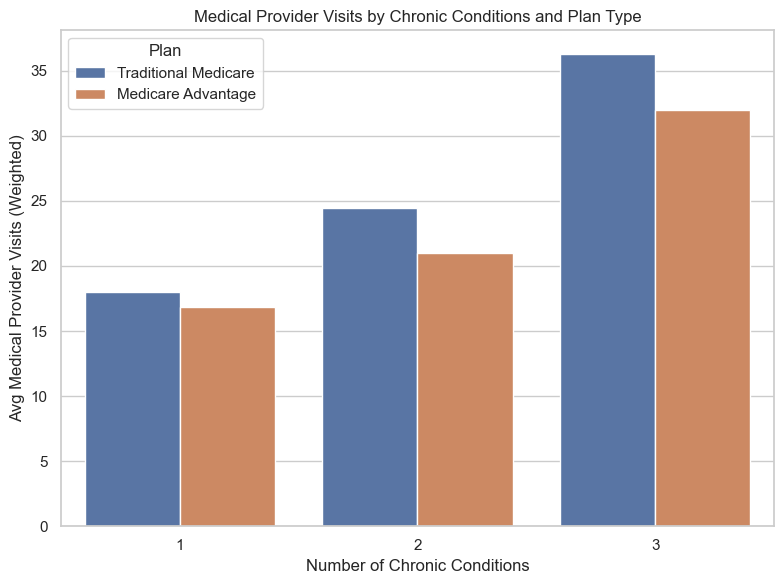

In [7]:
# Create DataFrame
visits_df = pd.DataFrame(summary_data)

# Plot: Provider visits by chronic condition and plan type
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(data=visits_df, x="Chronic Conditions", y="Visits", hue="Plan")
plt.title("Medical Provider Visits by Chronic Conditions and Plan Type")
plt.ylabel("Avg Medical Provider Visits (Weighted)")
plt.xlabel("Number of Chronic Conditions")
plt.tight_layout()
plt.show()



In [8]:
# Chronic Conditions Distribution (within-plan percentages)
chronic_trad = pd.Series([6222197, 19196771, 27256226], index=["1 condition", "2 conditions", "3+ conditions"])
chronic_adv = pd.Series([3119714, 9545606, 14113343], index=["1 condition", "2 conditions", "3+ conditions"])

chronic_df = pd.DataFrame({
    "Condition": chronic_trad.index,
    "Traditional Medicare (%)": (chronic_trad / chronic_trad.sum() * 100).values,
    "Medicare Advantage (%)": (chronic_adv / chronic_adv.sum() * 100).values
})



In [9]:
# Melt for seaborn
chronic_melted = chronic_df.melt(id_vars="Condition", var_name="Plan", value_name="Percentage")



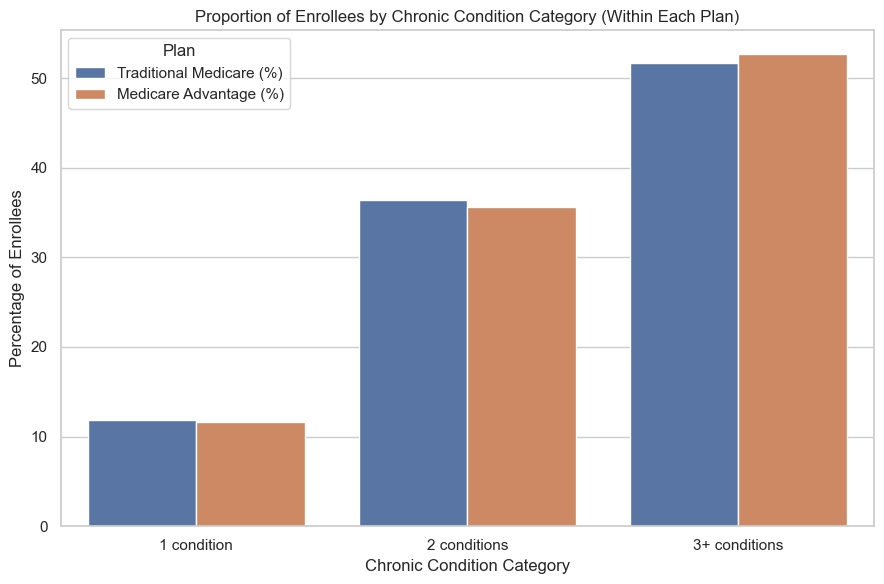

In [10]:
# Plot Chronic Conditions by percentage
plt.figure(figsize=(9, 6))
sns.barplot(data=chronic_melted, x="Condition", y="Percentage", hue="Plan")
plt.title("Proportion of Enrollees by Chronic Condition Category (Within Each Plan)")
plt.ylabel("Percentage of Enrollees")
plt.xlabel("Chronic Condition Category")
plt.tight_layout()
plt.show()

In [11]:

import statsmodels.formula.api as smf


# Clean and prepare
df["plan_ma"] = (df["PAMTMADV"] > 0).astype(int)
df["plan_tm"] = (df["PAMTCARE"] > 0).astype(int)

# Keep only people in either plan
df = df[(df["plan_ma"] == 1) | (df["plan_tm"] == 1)]

# Convert relevant columns to numeric
cols_to_convert = ["MPAEVNTS", "CSP_NCHRNCND", "CSP_AGE", "CSP_SEX", "CSP_INCOME", "CSPUFWGT"]
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop rows with missing data in key columns
df = df.dropna(subset=cols_to_convert)

# Run weighted least squares regression
model = smf.wls(
    formula="MPAEVNTS ~ plan_ma + CSP_NCHRNCND + C(CSP_AGE) + C(CSP_SEX) + C(CSP_INCOME)",
    data=df,
    weights=df["CSPUFWGT"]
).fit()

# View results
print(model.summary())


                            WLS Regression Results                            
Dep. Variable:               MPAEVNTS   R-squared:                       0.064
Model:                            WLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     71.41
Date:                Sat, 07 Jun 2025   Prob (F-statistic):           1.98e-86
Time:                        16:13:17   Log-Likelihood:                -31675.
No. Observations:                6295   AIC:                         6.336e+04
Df Residuals:                    6288   BIC:                         6.341e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.0459      2